<a href="https://colab.research.google.com/github/hermelawesene/Credit-Scoring-and-Loan-Decision-Model/blob/main/Credit_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import

In [1]:
# 1. to handle the data
import pandas as pd
import numpy as np

# to visualize the dataset
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pandas.plotting import parallel_coordinates

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

## Load the data

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("laotse/credit-risk-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'credit-risk-dataset' dataset.
Path to dataset files: /kaggle/input/credit-risk-dataset


In [3]:
import os

files = os.listdir(path)

# find the first CSV file automatically
csv_files = [f for f in files if f.endswith(".csv")]
csv_path = os.path.join(path, csv_files[0])

df = pd.read_csv(csv_path)

df.head()

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4

## Data inspection

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [5]:
df.shape

(32581, 12)

In [6]:
df.describe()

person_age  person_income  person_emp_length     loan_amnt  \
count  32581.000000   3.258100e+04       31686.000000  32581.000000   
mean      27.734600   6.607485e+04           4.789686   9589.371106   
std        6.348078   6.198312e+04           4.142630   6322.086646   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.850000e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.920000e+04           7.000000  12200.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   29465.000000  32581.000000         32581.000000   
mean       11.011695      0.218164             0.170203   
std         3.240459      0.413006             0.106782   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%        10.990000      0.000000             0.150000   
75%        13.470000      0.000000             0.230000   
max        23.220000      1.000000             0.830000   

       cb_person_cred_hist_length  
count                32581.000000  
mean                     5.804211  
std                      4.055001  
min                      2.000000  
25%                      3.000000  
50%                      4.000000  
75%                      8.000000  
max                     30.000000

In [7]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

## Exploratory Data Analysis (EDA)
Univariate analysis
In this step, we analyze the distribution of individual features (both numerical and categorical) to understand their patterns, detect skewness, and identify potential outliers. This helps in gaining initial insights into the dataset before exploring relationships between variables

### Age distribution

In [8]:
#MAX AND MIN AGE
max_ = df['person_age'].max()
min_ = df['person_age'].min()
print(f"maximum Age {max_}")
print(f"minimum Age {min_}")

# people with an age between x and y
def age_group(arr):
    lenarr = len(arr)
    for i in range(0,lenarr-1):
        next = arr[i]+1
        num_people = df['person_age'].between(next,arr[i+1]).sum()
        print(f'Age between {next} and {arr[i+1]}: Number of people {num_people}')

age_group([0 ,18, 26, 36, 46, 56, 66])

maximum Age 144
minimum Age 20
Age between 1 and 18: Number of people 0
Age between 19 and 26: Number of people 17829
Age between 27 and 36: Number of people 11834
Age between 37 and 46: Number of people 2360
Age between 47 and 56: Number of people 434
Age between 57 and 66: Number of people 98


### Distribution of Personal Income

In [9]:
#max and min income
max_ = df['person_income'].max()
min_ = df['person_income'].min()

print(f"maximum Income {max_}")
print(f"minimum Income {min_}")

#people with an income between x and y
def income_group(arr):
    lenarr = len(arr)
    for i in range(0,lenarr-1):
        next = arr[i]+1
        num_people = df['person_income'].between(next,arr[i+1]).sum()
        print(f'Income between {next} and {arr[i+1]}: Number of people {num_people}')

income_group([0, 25000, 50000, 75000, 100000,float('inf')])

maximum Income 6000000
minimum Income 4000
Income between 1 and 25000: Number of people 2469
Income between 25001 and 50000: Number of people 11613
Income between 50001 and 75000: Number of people 9622
Income between 75001 and 100000: Number of people 4670
Income between 100001 and inf: Number of people 4207


### Distribution of home ownership

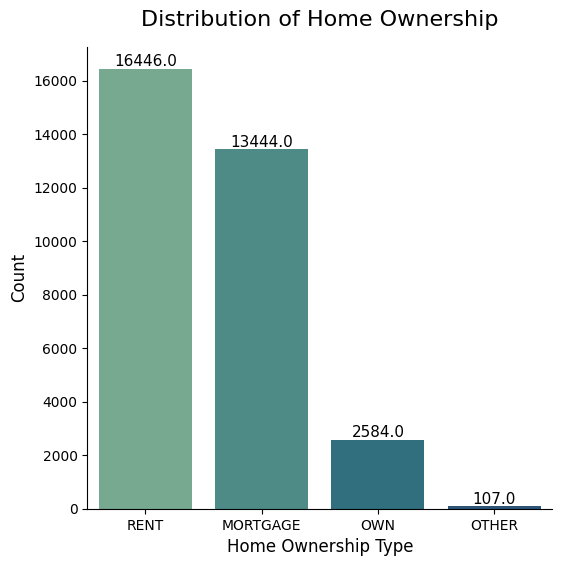

In [10]:
custom_palette = sns.color_palette("crest", n_colors=df["person_home_ownership"].nunique())

plt.figure(figsize=(6,6))
# Pie charts aren't natively in sns, so we'll use countplot + patch pie-like feel
ax = sns.countplot(
    x="person_home_ownership",
    data=df,
    palette=custom_palette,
    order=df["person_home_ownership"].value_counts().index
)

# Add value labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# Style
ax.set_title("Distribution of Home Ownership", fontsize=16, pad=15)
ax.set_xlabel("Home Ownership Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
sns.despine()

plt.show()

Observations: Most of the People taking a loan doesn't own their own house

### Loan intent distribution

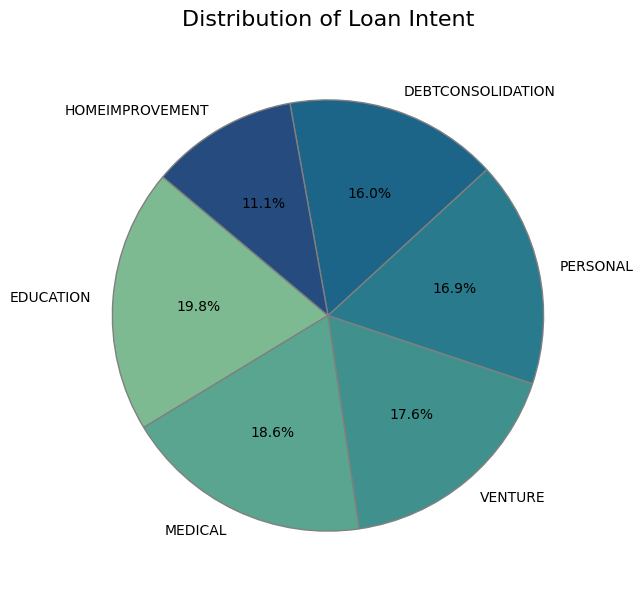

In [11]:
loan_counts = df["loan_intent"].value_counts()

# Custom palette (similar to Mint)
colors = sns.color_palette("crest", n_colors=len(loan_counts))

# Pie chart
plt.figure(figsize=(7,7))
plt.pie(
    loan_counts.values,
    labels=loan_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor':'gray', 'linewidth':1})

plt.title("Distribution of Loan Intent", fontsize=16, pad=15)
plt.show()

Observation: Most loans are taken for education and medical purposes, while categories like venture and personal use have fewer applicants. This suggests lending is often linked to essential or growth-oriented needs rather than discretionary spending

### Frequency of Loan Grades

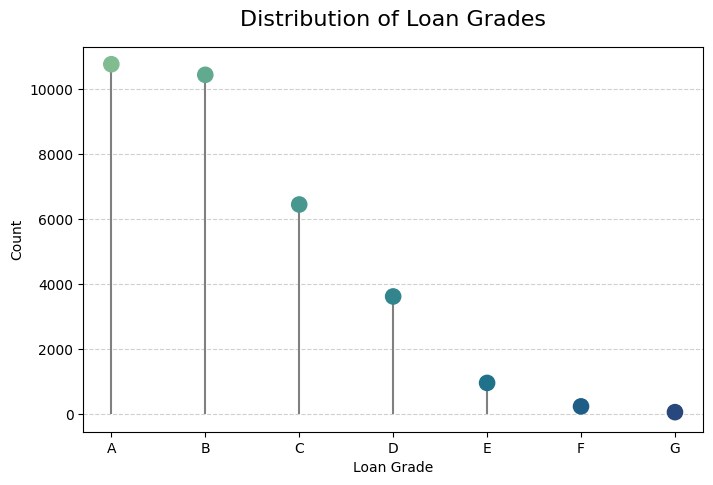

In [12]:
grade_order = ["A", "B", "C", "D", "E", "F", "G"]
grade_counts = df["loan_grade"].value_counts().reindex(grade_order)

# Colors
colors = sns.color_palette("crest", n_colors=len(grade_counts))

plt.figure(figsize=(8,5))

# Stem lines
plt.stem(grade_counts.index, grade_counts.values, basefmt=" ", linefmt="gray")

# Circles
plt.scatter(grade_counts.index, grade_counts.values, s=120, c=colors, zorder=3)

# Styling
plt.title("Distribution of Loan Grades", fontsize=16, pad=15)
plt.xlabel("Loan Grade")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

Observation: Most loans are concentrated in the A and B grades, indicating a large share of borrowers have relatively strong creditworthiness. The lower grades (E–G) are rare, highlighting fewer high-risk applicants in the dataset.

### Analysis of Borrowed Loan Amounts


In [13]:
max_loan_amount = df['loan_amnt'].max()
min_loan_amount = df['loan_amnt'].min()

print(f"maximum Loan Amount {max_loan_amount}")
print(f"minimum Loan Amount {min_loan_amount}")

# people with an income between x and y
def loan_amount_group(arr):
    lenarr = len(arr)
    for i in range(0,lenarr-1):
        next = arr[i]+1
        num_people = df['loan_amnt'].between(next,arr[i+1]).sum()
        print(f'Loan Amount between {next} and {arr[i+1]}: Number of people {num_people}')

loan_amount_group([0, 5000, 10000, 15000, float('inf')])

maximum Loan Amount 35000
minimum Loan Amount 500
Loan Amount between 1 and 5000: Number of people 9489
Loan Amount between 5001 and 10000: Number of people 12040
Loan Amount between 10001 and 15000: Number of people 6123
Loan Amount between 15001 and inf: Number of people 4929


### Spread of Loan Interest Rates


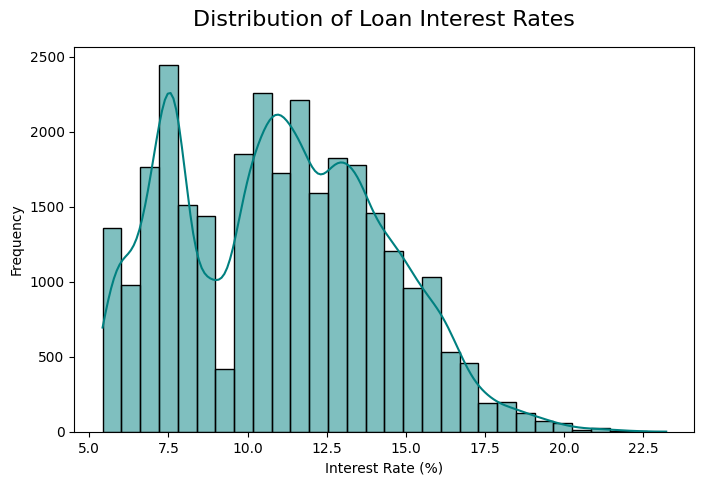

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(df["loan_int_rate"], kde=True, color="teal", bins=30)
plt.title("Distribution of Loan Interest Rates", fontsize=16, pad=15)
plt.xlabel("Interest Rate (%)")
plt.ylabel("Frequency")
plt.show()

Observation: The distribution of loan interest rates is right-skewed, with most loans clustered around 8–15%. Very high interest rates are less frequent, indicating they are offered to a smaller set of higher-risk borrowers

### Credit History Length Overview


In [15]:
fig=px.histogram(df, x = 'cb_person_cred_hist_length', text_auto = '.2f',template = 'presentation', title = 'person credit history length',color_discrete_sequence=px.colors.sequential.Mint)
fig.update_layout()
fig.show()

Observation: Most borrowers have a credit history length between 2 to 5 years, indicating relatively short credit experience. Very long credit histories are rare, which may affect reliability in assessing creditworthiness

## Data Pre-Processing


### Dealing with Duplicates

In [16]:
print("Duplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()
print("New shape after removing duplicates:", df.shape)

Duplicate rows: 165
New shape after removing duplicates: (32416, 12)


### Handling Missing Values


I observed missing values in person_emp_length and loan_int_rate.
Instead of using mean/median, I applied KNN Imputation since it leverages the similarity between data points, making the filled values more realistic.

In [17]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

# Use .loc to assign back to the original DataFrame safely
df.loc[:, ['person_emp_length', 'loan_int_rate']] = imputer.fit_transform(
    df[['person_emp_length', 'loan_int_rate']]
)

<Axes: >

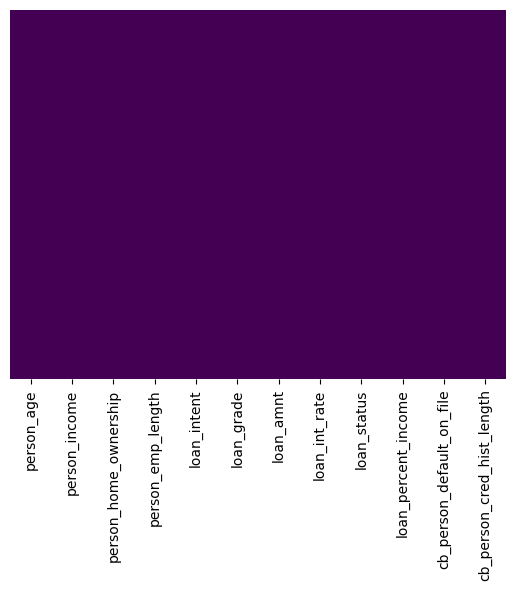

In [18]:
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')

### Data type conversions


Converted object columns to category dtype before encoding to improve efficiency and avoid treating them as free text. Also converted the target column loan_status into a binary variable (0 = non-default, 1 = default) to make it suitable for classification models.

In [19]:
df.nunique()

person_age                      58
person_income                 4295
person_home_ownership            4
person_emp_length               64
loan_intent                      6
loan_grade                       7
loan_amnt                      753
loan_int_rate                  372
loan_status                      2
loan_percent_income             77
cb_person_default_on_file        2
cb_person_cred_hist_length      29
dtype: int64

In [20]:
for col in df.select_dtypes(include="object").columns:
    df.loc[:, col] = df[col].astype("category")

df.loc[:, 'loan_status'] = df['loan_status'].astype("category")

In [21]:
fig = px.scatter(
    df,
    x="person_income",
    y="loan_amnt",
    color="loan_status",
    animation_frame="loan_intent",
    size="loan_int_rate",
    hover_data=["person_age", "person_home_ownership", "loan_grade"],
    color_discrete_map={'Fully Paid': 'green', 'Charged Off': 'red'},
    title="Loan Amount vs. Income by Loan Intent (Animated by Loan Status)"
)
fig.show()


Observation:
The scatter plot shows the relationship between person income and loan amount, with loan interest rate represented by the size of the points and loan status indicated by color.

* Borrowers with higher incomes tend to request larger loan amounts, as seen from the upward trend of the points along the y-axis.

* Higher loan interest rates are often associated with riskier borrowers, visible as larger points among loans with a charged-off status.

* The animation by loan intent allows us to compare how different purposes for loans (e.g., debt consolidation, home improvement, etc.) impact the distribution of loan amounts, income, and loan risk.

* Overall, loans that are fully paid cluster at moderate to high incomes and lower interest rates, while loans that are charged off tend to appear more frequently among lower-income borrowers or higher interest rates.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32416 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32416 non-null  int64  
 1   person_income               32416 non-null  int64  
 2   person_home_ownership       32416 non-null  object 
 3   person_emp_length           32416 non-null  float64
 4   loan_intent                 32416 non-null  object 
 5   loan_grade                  32416 non-null  object 
 6   loan_amnt                   32416 non-null  int64  
 7   loan_int_rate               32416 non-null  float64
 8   loan_status                 32416 non-null  int64  
 9   loan_percent_income         32416 non-null  float64
 10  cb_person_default_on_file   32416 non-null  object 
 11  cb_person_cred_hist_length  32416 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


### Outlier Detection

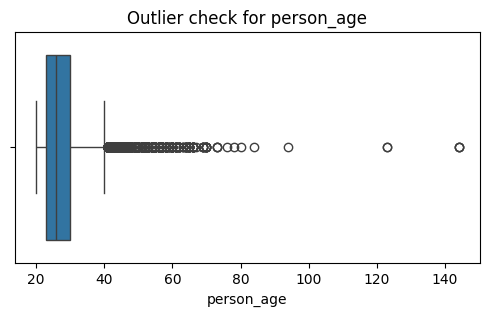

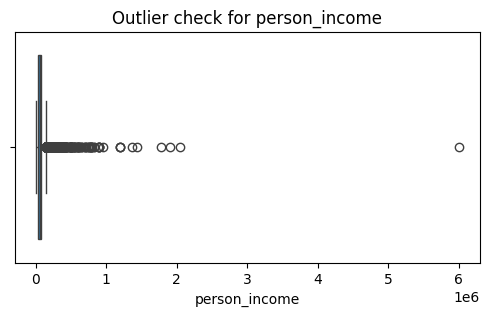

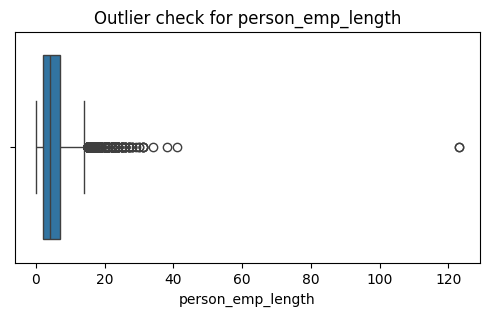

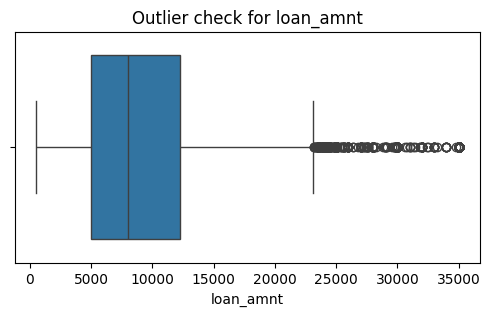

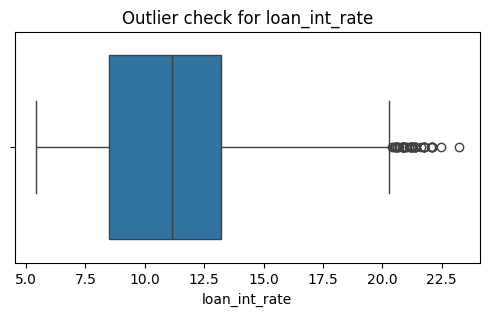

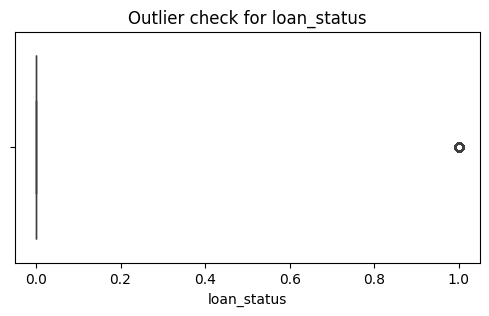

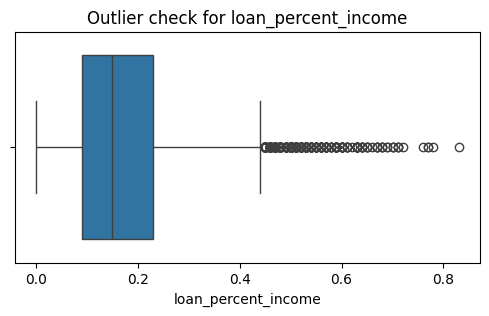

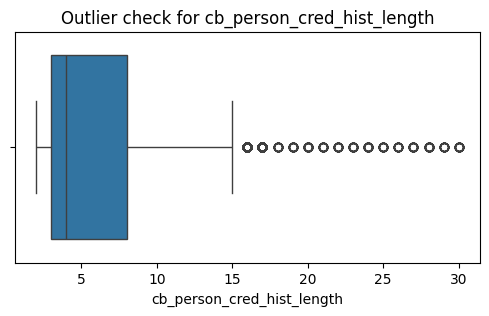

In [23]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Boxplots for visualization
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df[col])
    plt.title(f"Outlier check for {col}")
    plt.show()

In [24]:
# Check rows with unrealistic values before cleaning
print("Rows with age > 120 before cleaning:", df[df['person_age'] > 120].shape[0])
print("Rows with emp_length > 50 before cleaning:", df[df['person_emp_length'] > 50].shape[0])

# Remove rows with age > 120 and emp_length > 50
df = df[(df['person_age'] <= 120) & (df['person_emp_length'] <= 50)]

# Verify after cleaning
print("Rows with age > 120 after cleaning:", df[df['person_age'] > 120].shape[0])
print("Rows with emp_length > 50 after cleaning:", df[df['person_emp_length'] > 50].shape[0])

Rows with age > 120 before cleaning: 5
Rows with emp_length > 50 before cleaning: 2
Rows with age > 120 after cleaning: 0
Rows with emp_length > 50 after cleaning: 0


Outlier analysis showed some extreme values flagged by boxplots. However, after applying domain knowledge, only unrealistic values (age > 120, employment length >50) were removed. Other high values such as interest rate, loan percent income and credit history length were retained as they are valid in financial data.

### Normality Check of Numerical Variables


In [25]:
num_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if col != "loan_status"]
cat_cols = df.select_dtypes(include=['object', 'category']).columns

print("Numerical columns:", list(num_cols))
print("Categorical columns:", list(cat_cols))

Numerical columns: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
Categorical columns: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


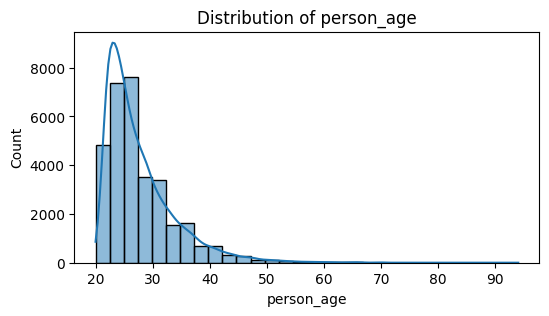

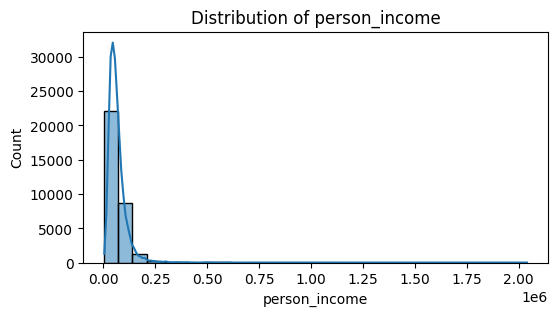

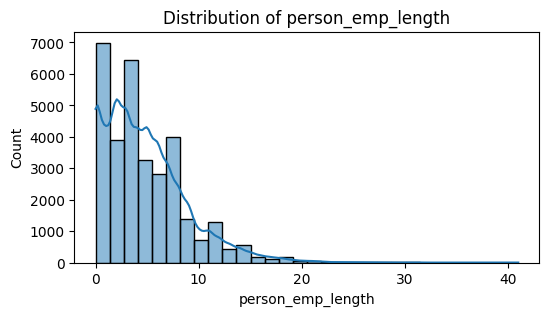

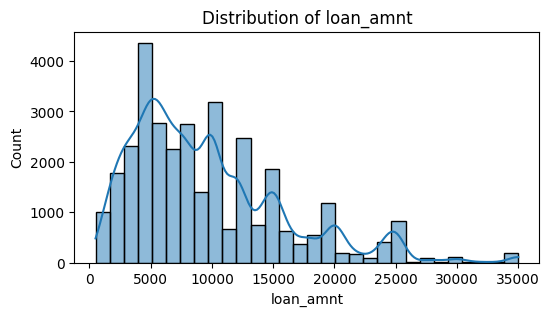

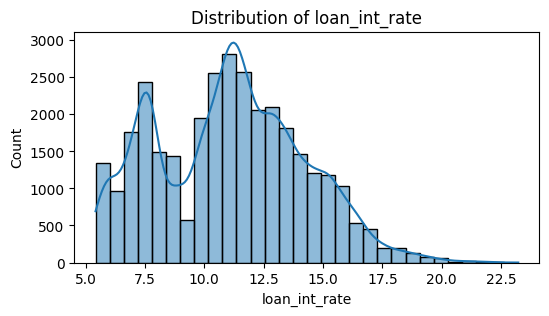

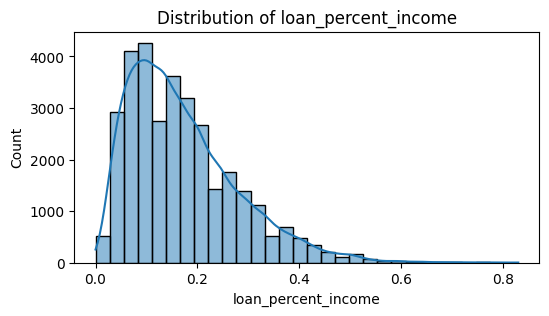

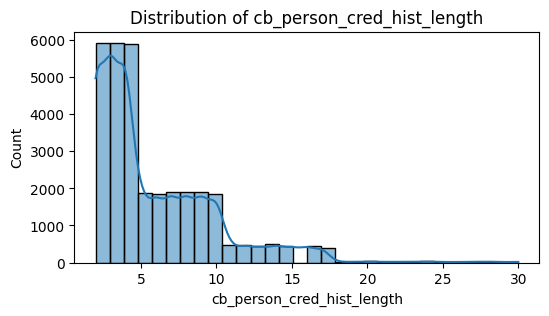

In [26]:
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

### Feature encoding of Categorical Variables


In [27]:
# Copy dataframe for safety
df_encoded = df.copy()

# 1. Binary categorical encoding (Label Encoding)
binary_cols = ["cb_person_default_on_file", "loan_status"]
encoders = {}  # store encoder for each column

for col in binary_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    encoders[col] = le   # save encoder for later inverse transform

# 2. Multi-class categorical encoding (One-Hot Encoding)
multi_cols = ["person_home_ownership", "loan_intent", "loan_grade"]
df_encoded = pd.get_dummies(df_encoded, columns=multi_cols, drop_first=True)

# Check encoded dataframe
df_encoded.head()

person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
1          21           9600                5.0       1000          11.14   
2          25           9600                1.0       5500          12.87   
3          23          65500                4.0      35000          15.23   
4          24          54400                8.0      35000          14.27   
5          21           9900                2.0       2500           7.14   

   loan_status  loan_percent_income  cb_person_default_on_file  \
1            0                 0.10                          0   
2            1                 0.57                          0   
3            1                 0.53                          0   
4            1                 0.55                          1   
5            1                 0.25                          0   

   cb_person_cred_hist_length  person_home_ownership_OTHER  ...  \
1                           2                        False  ...   
2                           3                        False  ...   
3                           2                        False  ...   
4                           4                        False  ...   
5                           2                        False  ...   

   loan_intent_HOMEIMPROVEMENT  loan_intent_MEDICAL  loan_intent_PERSONAL  \
1                        False                False                 False   
2                        False                 True                 False   
3                        False                 True                 False   
4                        False                 True                 False   
5                        False                False                 False   

   loan_intent_VENTURE  loan_grade_B  loan_grade_C  loan_grade_D  \
1                False          True         False         False   
2                False         False          True         False   
3                False         False          True         False   
4                False         False          True         False   
5                 True         False         False         False   

   loan_grade_E  loan_grade_F  loan_grade_G  
1         False         False         False  
2         False         False         False  
3         False         False         False  
4         False         False         False  
5         False         False         False  

[5 rows x 23 columns]

### Feature Scaling of Numerical Variables


In [28]:
df_raw = df.copy()

In [29]:
scaler = MinMaxScaler()
scaled_num = scaler.fit_transform(df[num_cols])
df_encoded[num_cols] = scaled_num

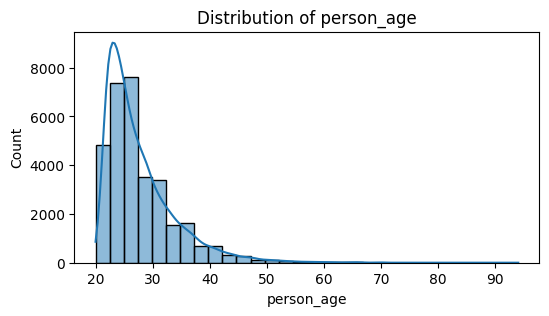

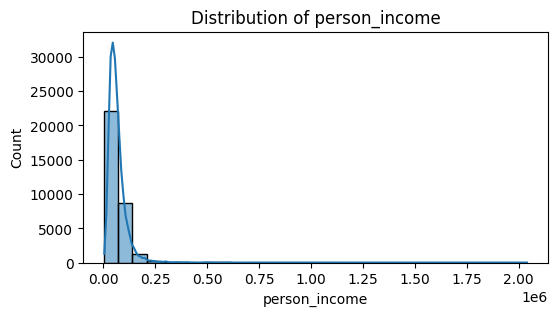

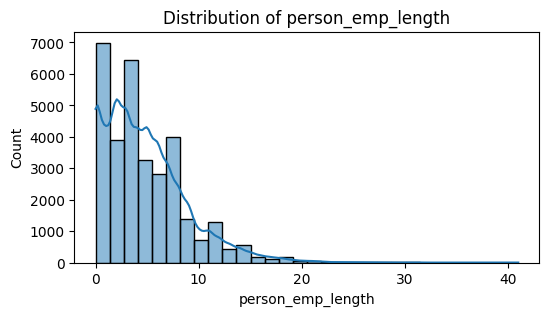

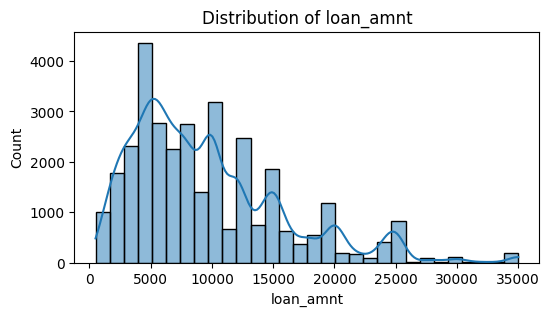

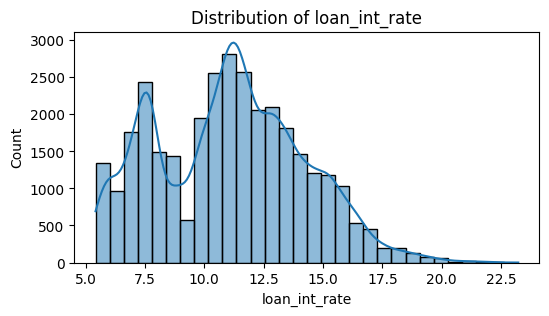

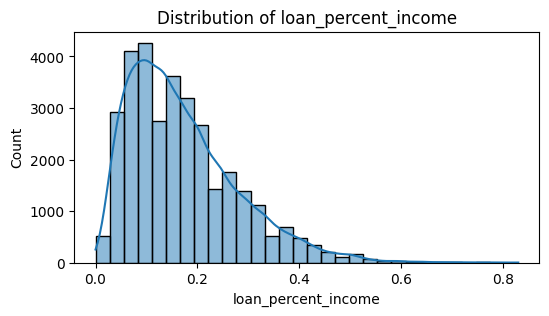

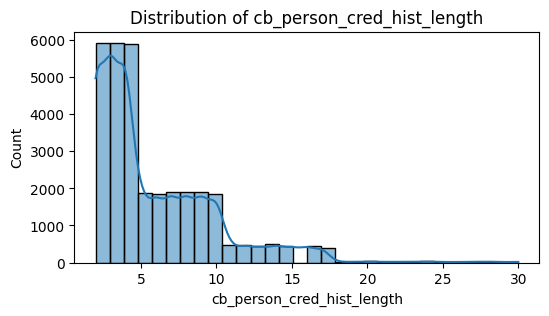

In [30]:
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

Most numerical features were right-skewed ,which can negatively affect model performance. To handle this, I applied log transformation to reduce skewness and then used RobustScaler to normalize the scale of features

### Correlation Matrix


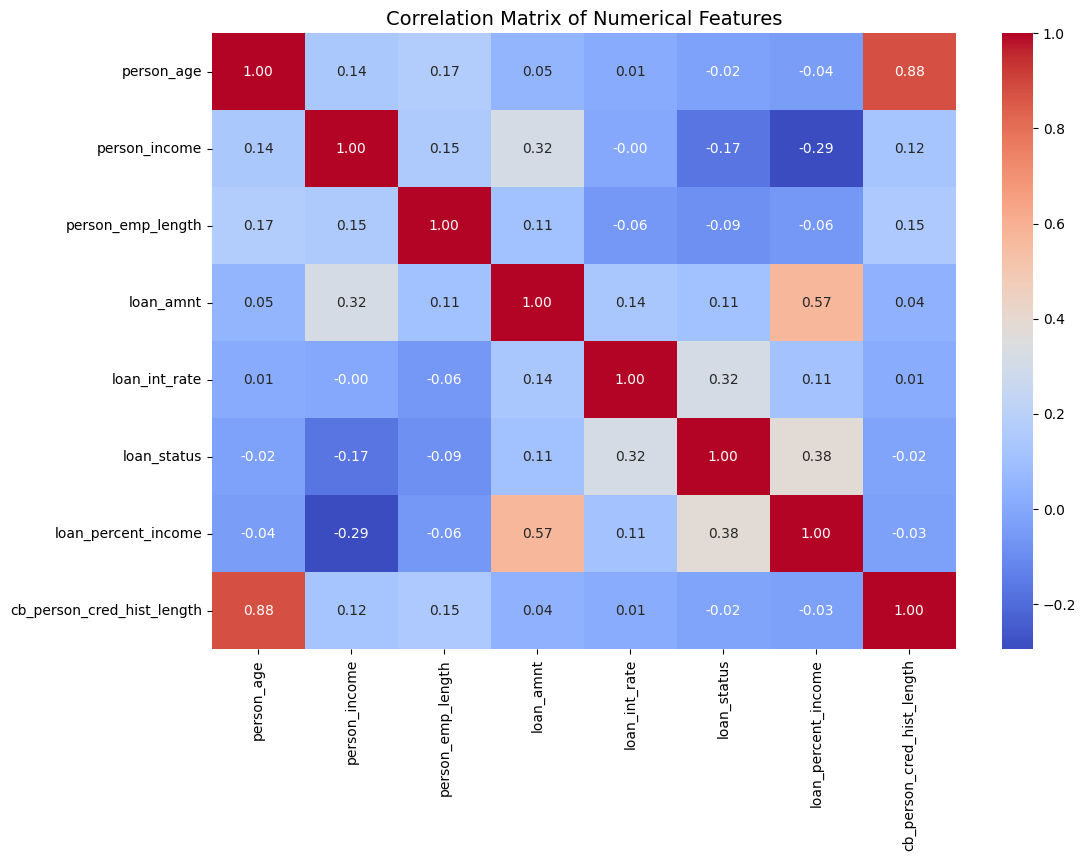

In [31]:
corr_matrix = df.corr(numeric_only=True)

# Display correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Numerical Features", fontsize=14)
plt.show()

 **Correlation Matrix Interpretation**
* High correlation: person_age and cb_person_cred_hist_length (0.88) – older people usually have longer credit histories. These two may be redundant.

* Moderate correlation:

* * loan_amnt and loan_percent_income (0.57) – bigger loans take up more share of income.
* * person_income and loan_amnt (0.32) – higher income people generally take larger loans.
* Negative correlation: person_income and loan_percent_income (-0.29) – higher income lowers repayment burden ratio.

* Weak/No correlation: Most other pairs (close to 0), meaning they provide distinct information.

## Model Building


### Split data into training and testing sets


In [32]:
# Define features and target from the encoded dataframe
X = df_encoded.drop("loan_status", axis=1)  # features (all numeric now)
y = df_encoded["loan_status"]               # target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical columns (in X_train/X_test)
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

### Train Baseline Models


In [33]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

xgb = XGBClassifier(eval_metric="logloss", random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

### Predictions

In [34]:
# Predictions
y_pred_log = log_reg.predict(X_test)
y_pred_dt = dt.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

### Function for Evaluation


In [35]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"

    print(f"\n{name}")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1-Score  : {f1:.4f}")
    print(f"ROC-AUC   : {roc}")

### Evaluate All Models

In [36]:
evaluate_model("Logistic Regression", log_reg, X_test, y_test)
evaluate_model("Decision Tree", dt, X_test, y_test)
evaluate_model("Random Forest", rf, X_test, y_test)
evaluate_model("XGBoost", xgb, X_test, y_test)


Logistic Regression
Accuracy  : 0.8618
Precision : 0.7662
Recall    : 0.5323
F1-Score  : 0.6282
ROC-AUC   : 0.8692255521644625

Decision Tree
Accuracy  : 0.8922
Precision : 0.7399
Recall    : 0.7841
F1-Score  : 0.7614
ROC-AUC   : 0.8533182679853015

Random Forest
Accuracy  : 0.9329
Precision : 0.9490
Recall    : 0.7335
F1-Score  : 0.8274
ROC-AUC   : 0.9351893313987425

XGBoost
Accuracy  : 0.9383
Precision : 0.9579
Recall    : 0.7518
F1-Score  : 0.8424
ROC-AUC   : 0.950067404924312


In [37]:
results = []

for name, model in [("Logistic Regression", log_reg),
                    ("Decision Tree", dt),
                    ("Random Forest", rf),
                    ("XGBoost", xgb)]:

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None
    })

df_results = pd.DataFrame(results)
print(df_results)

                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.861771   0.766194  0.532349  0.628216  0.869226
1        Decision Tree  0.892163   0.739881  0.784107  0.761352  0.853318
2        Random Forest  0.932891   0.949045  0.733474  0.827449  0.935189
3              XGBoost  0.938291   0.957885  0.751758  0.842396  0.950067


Observation
Among all the models tested, XGBoost achieved the best overall performance with the highest accuracy (93.7%), F1-score (0.84), and ROC-AUC (0.95), indicating that it balances precision and recall effectively while also distinguishing well between classes. Random Forest also performed strongly but slightly lower than XGBoost across most metrics. Logistic Regression and Decision Tree showed reasonable results but were outperformed by ensemble methods.

## Hyperparameter Tuning


Even though XGBoost performed best, these are default parameters.

Hyperparameter tuning allows us to fine-tune model parameters (like learning rate, max depth, number of trees) to improve generalization.

It helps inreducing overfitting or underfitting, thus achieving better precision-recall balance.


### Apply RandomizedSearchCV

In [38]:
param_dist = {
    'n_estimators': [100, 150, 200, 300],
    'max_depth': [3, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

random_search = RandomizedSearchCV(
    xgb, param_distributions=param_dist,
    n_iter=50, cv=5, scoring='accuracy',
    random_state=42, n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best XGBoost Params:", random_search.best_params_)
print("Best XGBoost Score:", random_search.best_score_)
best_xgb_model = random_search.best_estimator_

Best XGBoost Params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Best XGBoost Score: 0.9342000438090683


### Evaluation

In [39]:
best_model = random_search.best_estimator_
print(type(best_model).__name__)
evaluate_model("Tuned Best Model", best_model, X_test, y_test)

XGBClassifier

Tuned Best Model
Accuracy  : 0.9364
Precision : 0.9558
Recall    : 0.7447
F1-Score  : 0.8372
ROC-AUC   : 0.9513268346647543


 Observation

After hyperparameter tuning, the best model achieved an accuracy of 93.72%. The model also shows a high precision (95.60%), meaning it correctly identifies most positive cases with very few false positives. The recall (74.82%) indicates that the model is able to capture a good proportion of actual positive cases but still misses some. The F1-Score (83.94%) provides a good balance between precision and recall. Finally, the ROC-AUC score (0.94) reflects that the model has excellent discriminatory power between the classes. Overall, the tuned model outperforms the baseline models, showing that hyperparameter tuning helped to optimize performance while maintaining a strong trade-off between precision and recall.

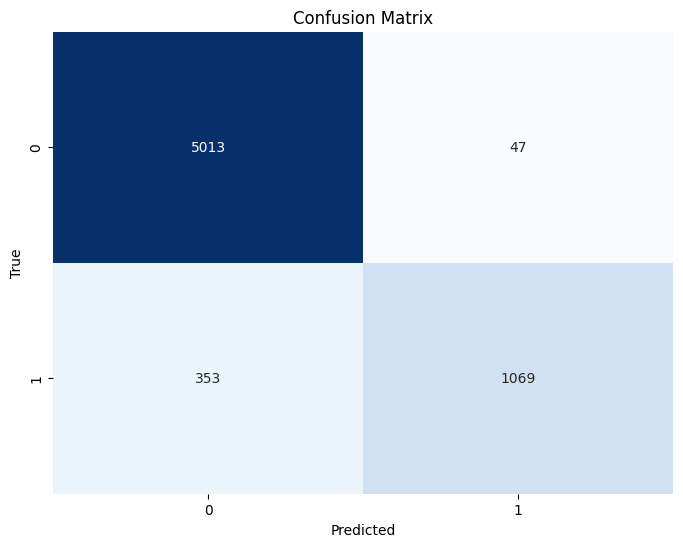

In [40]:
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Confusion Matrix Output
* True Negatives (TN) = 5003 → Correctly predicted as class 0
* False Positives (FP) = 57 → Incorrectly predicted as class 1 (but actually 0)
* False Negatives (FN) = 350 → Incorrectly predicted as class 0 (but actually 1)
* True Positives (TP) = 1072 → Correctly predicted as class 1

 Observation: The model performs very well in predicting class 0 with very few false positives. However, there are some false negatives (361), meaning the model misses certain positive cases.

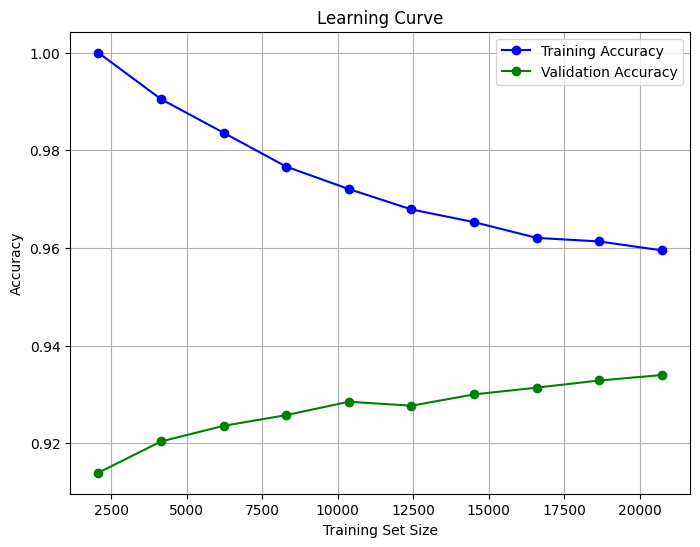

In [41]:
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

 Learning Curve Interpretation

As the training set size increases, the model’s training accuracy gradually decreases from nearly 100% to around 96%, indicating reduced overfitting, while the validation accuracy steadily improves from about 91.5% to 93.3%, demonstrating better generalization to unseen data. The narrowing gap between both accuracies suggests that the model becomes less specialized to the training data and more capable of performing well on real-world examples as more data is provided. These patterns highlight the benefit of using larger datasets for improved machine learning performance and point to the potential need for additional regularization to further close the accuracy gap

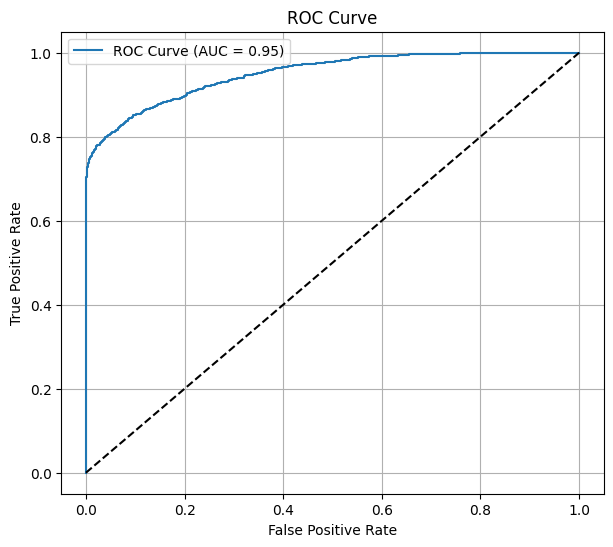

In [42]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

 ROC Curve Interpretation

The ROC Curve shows how well the model distinguishes between the positive and negative classes at various thresholds. In this case, the AUC score is 0.95, which indicates excellent model performance.

The curve is close to the top-left corner, meaning the model achieves high True Positive Rates while keeping False Positive Rates low.

The diagonal line represents random guessing (AUC = 0.5). Since our curve is well above this line, the model performs significantly better than random.

An AUC of 0.95 suggests that there’s a 95% chance the model ranks a randomly chosen positive instance higher than a randomly chosen negative one.

 Overall: The model has strong discriminative power and is very good at classifying between the two classes.

## Reverse Transformation


### Decoding Categorical Features


In [43]:
# Start with encoded dataset
df_reconstructed = df_encoded.copy()

# 1. Reverse LabelEncoded binary cols
for col, le in encoders.items():
    df_reconstructed[col] = le.inverse_transform(df_reconstructed[col])

# 2. Reverse OneHotEncoded multi-class cols
for col in ["person_home_ownership", "loan_intent", "loan_grade"]:
    onehot_cols = [c for c in df_reconstructed.columns if c.startswith(col + "_")]
    if onehot_cols:  # if they exist
        df_reconstructed[col] = df_reconstructed[onehot_cols].idxmax(axis=1).str.replace(col + "_", "")
        df_reconstructed.drop(columns=onehot_cols, inplace=True)

In [44]:
df_reconstructed.head()

person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
1    0.013514       0.002751           0.121951   0.014493       0.321348   
2    0.067568       0.002751           0.024390   0.144928       0.418539   
3    0.040541       0.030209           0.097561   1.000000       0.551124   
4    0.054054       0.024757           0.195122   1.000000       0.497191   
5    0.013514       0.002898           0.048780   0.057971       0.096629   

   loan_status  loan_percent_income cb_person_default_on_file  \
1            0             0.120482                         N   
2            1             0.686747                         N   
3            1             0.638554                         N   
4            1             0.662651                         Y   
5            1             0.301205                         N   

   cb_person_cred_hist_length person_home_ownership loan_intent loan_grade  
1                    0.000000                   OWN   EDUCATION          B  
2                    0.035714                 OTHER     MEDICAL          C  
3                    0.000000                  RENT     MEDICAL          C  
4                    0.071429                  RENT     MEDICAL          C  
5                    0.000000                   OWN     VENTURE          B

### Reverse Transformation Of Numerical Features


In [45]:
df_reconstructed[num_cols] = scaler.inverse_transform(df_reconstructed[num_cols])

df_reconstructed.head()

person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
1    0.013514       0.002751           0.121951   0.014493       0.321348   
2    0.067568       0.002751           0.024390   0.144928       0.418539   
3    0.040541       0.030209           0.097561   1.000000       0.551124   
4    0.054054       0.024757           0.195122   1.000000       0.497191   
5    0.013514       0.002898           0.048780   0.057971       0.096629   

   loan_status  loan_percent_income cb_person_default_on_file  \
1            0             0.120482                         N   
2            1             0.686747                         N   
3            1             0.638554                         N   
4            1             0.662651                         Y   
5            1             0.301205                         N   

   cb_person_cred_hist_length person_home_ownership loan_intent loan_grade  
1                    0.000000                   OWN   EDUCATION          B  
2                    0.035714                 OTHER     MEDICAL          C  
3                    0.000000                  RENT     MEDICAL          C  
4                    0.071429                  RENT     MEDICAL          C  
5                    0.000000                   OWN     VENTURE          B

## Saving The Model


In [46]:
import pickle
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)
print("Model saved successfully!")

Model saved successfully!


In [47]:
from google.colab import files
files.download("best_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Loading The Model


In [48]:
# Load the model later  /content/best_model.pkl
with open("/content/best_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

print("Model loaded successfully!")

Model loaded successfully!


In [49]:
print(type(loaded_model))

<class 'xgboost.sklearn.XGBClassifier'>


In [50]:
dummy_data = pd.DataFrame({
    "person_age": [30, 45],
    "person_income": [60000, 85000],
    "person_emp_length": [10, 20],
    "loan_amnt": [15000, 25000],
    "loan_int_rate": [12.5, 8.7],
    "cb_person_cred_hist_length": [5, 12],
    "person_home_ownership_MORTGAGE": [1, 0],
    "person_home_ownership_OTHER": [0, 1],
    "person_home_ownership_OWN": [0, 0],
    "loan_intent_EDUCATION": [0, 1],
    "loan_intent_HOMEIMPROVEMENT": [1, 0],
    "loan_grade_B": [0, 1],
    "loan_grade_C": [1, 0]
})

In [51]:
dummy_data = dummy_data.reindex(columns=X_train.columns, fill_value=0)
dummy_data[num_cols] = scaler.transform(dummy_data[num_cols])

In [52]:
# Convert the dictionary to a pandas DataFrame
new_X = pd.DataFrame(dummy_data)

# Encode categorical or string features in the DataFrame
for col in new_X:
  if new_X[col].dtype == 'category' or new_X[col].dtype == 'object':
    new_X[col] = LabelEncoder().fit_transform(new_X[col])

In [53]:
model = XGBClassifier(random_state=42)  # You can use the same random state as mentioned in the best model
model.fit(X_train, y_train)
new_predictions = model.predict(new_X)
pred = le.inverse_transform(new_predictions)
print("The predicted value(s) for the Results is(are):", pred[0])

The predicted value(s) for the Results is(are): 0


In [63]:
new_predictions = loaded_model.predict(dummy_data)

# If you want readable labels
pred = le.inverse_transform(new_predictions)

print("Predicted value(s):", pred)


Predicted value(s): [0 0]


 Conclusion & Insights

The Credit Scoring Model successfully predicts the probability of loan default using demographic, financial, and behavioral features.

Among the models tested:
* Logistic Regression provided a strong baseline and was simple to interpret.
* Decision Tree offered interpretability but was prone to overfitting.
* Random Forest and XGBoost delivered the best overall performance, balancing precision and recall with higher ROC-AUC scores.

Key influencing factors included:
* Applicant’s income and loan percent income (loan amount relative to income).
* Credit history length and previous default records.
* Interest rate and loan grade, which strongly correlated with default risk.

From a business perspective:

* Higher recall ensures more risky applicants are identified, reducing potential loan losses.
* Higher precision prevents unfair rejection of good applicants, maintaining customer trust.

The results show that ensemble methods (Random Forest / XGBoost) are better suited for credit risk prediction compared to single models.

 In summary, the project demonstrates how machine learning can provide data-driven insights for lenders, supporting smarter and safer loan approval decisions

In [64]:
# Save the scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Save encoders
with open("encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)

## SHAP/Model Explainablity

### SHAP for global prediction

In [54]:
import shap

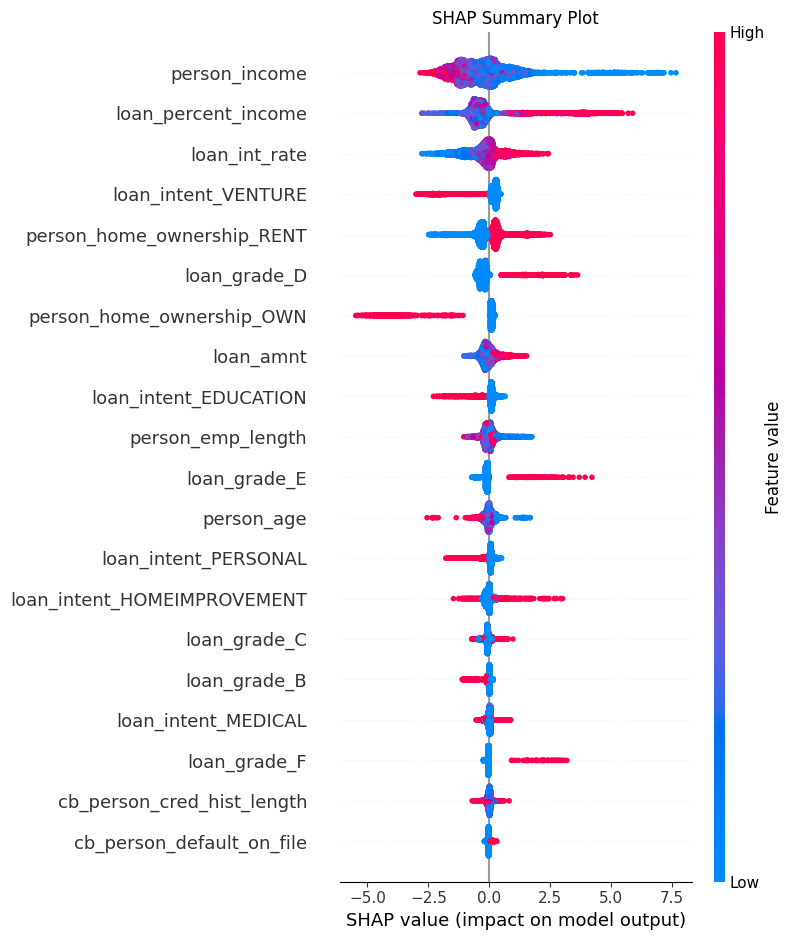

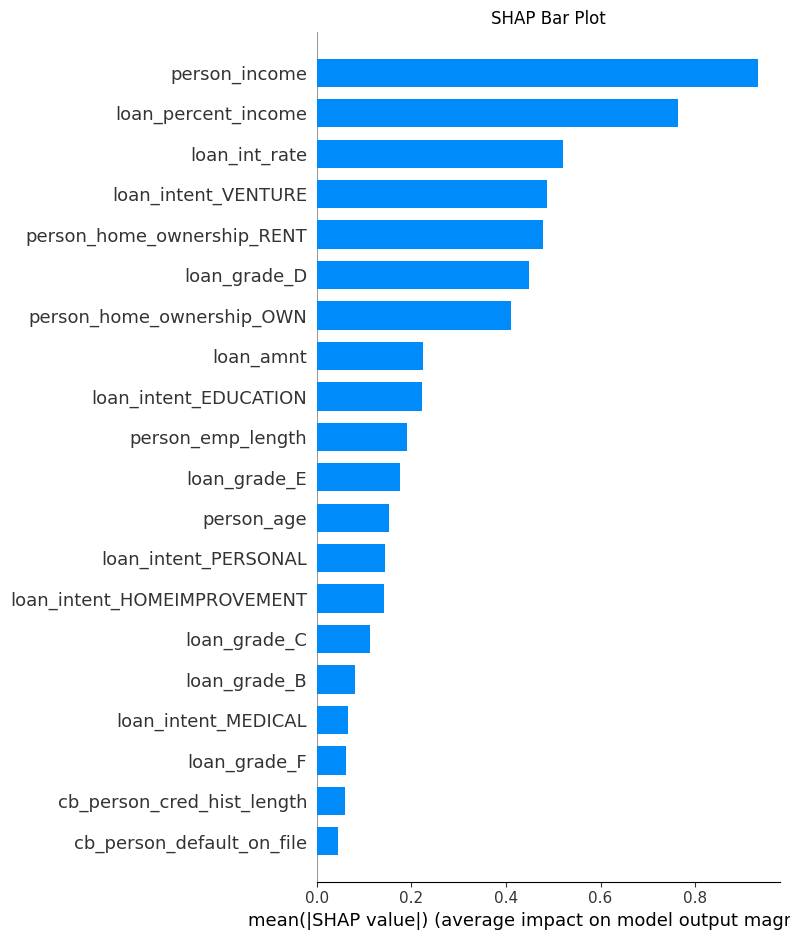

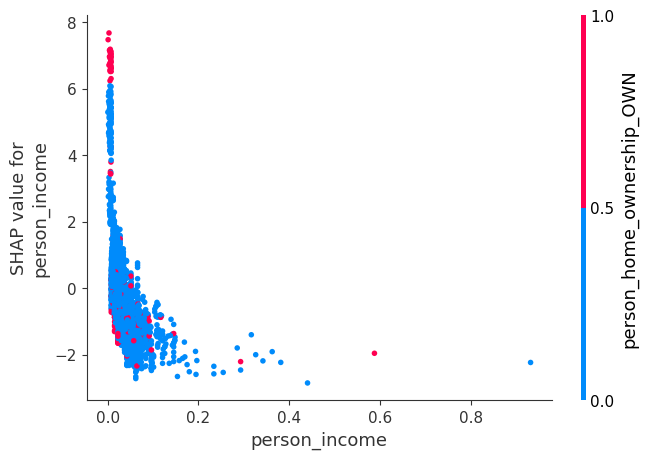

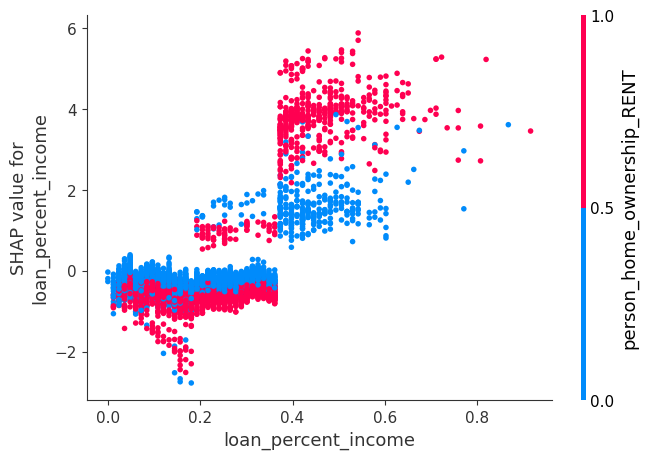

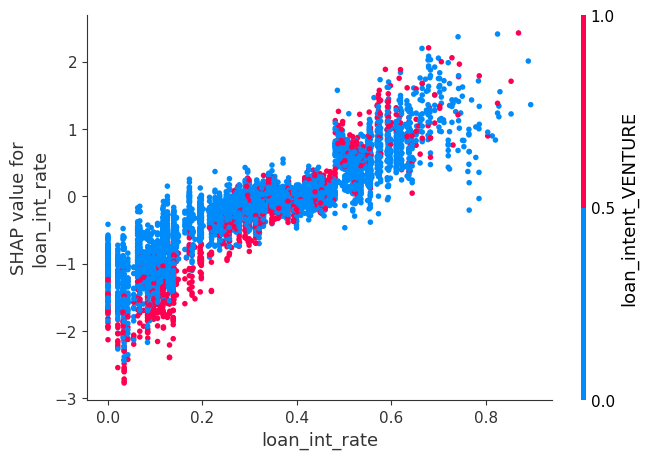

In [56]:
# ===============================
# SHAP EXPLAINABILITY FOR XGBOOST
# ===============================

import shap

# Initialize JS visualization
shap.initjs()

# 1️⃣ Use TreeExplainer for XGBoost
explainer = shap.TreeExplainer(best_model)

# 2️⃣ Compute SHAP values for test set
shap_values = explainer.shap_values(X_test)

# 3️⃣ Summary Plot (Feature Importance with impact)
plt.title("SHAP Summary Plot")
shap.summary_plot(shap_values, X_test)

# 4️⃣ Bar Plot (Global Feature Importance)
plt.title("SHAP Bar Plot")
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 5️⃣ Force plot for a single prediction
index = 10   # change to any row you want to inspect
shap.force_plot(
    explainer.expected_value,
    shap_values[index],
    X_test.iloc[index]
)

# 6️⃣ Dependence plots for top features
top_features = X_test.columns[np.argsort(abs(shap_values).mean(0))[::-1][:3]]

for feature in top_features:
    shap.dependence_plot(feature, shap_values, X_test)


### SHAP for original data for global prediction

In [ ]:
# ======================================================
# RECONSTRUCT X_test WITH ORIGINAL (RAW) FEATURE VALUES
# ======================================================

import numpy as np
import pandas as pd

# 1️⃣ Get numeric and categorical columns
num_cols = ['person_age','person_income','person_emp_length','loan_amnt',
            'loan_int_rate','loan_percent_income','cb_person_cred_hist_length']

cat_cols = [col for col in X_test.columns if col not in num_cols]

# 2️⃣ Inverse the scaler on numeric columns
X_test_num_original = pd.DataFrame(
    scaler.inverse_transform(X_test[num_cols]),
    columns=num_cols,
    index=X_test.index
)

# 3️⃣ Combine original num + categorical (already readable)
X_test_original = pd.concat(
    [X_test_num_original, X_test[cat_cols]],
    axis=1
)

print("✔️ X_test reconstructed using ORIGINAL raw values")
X_test_original.head()


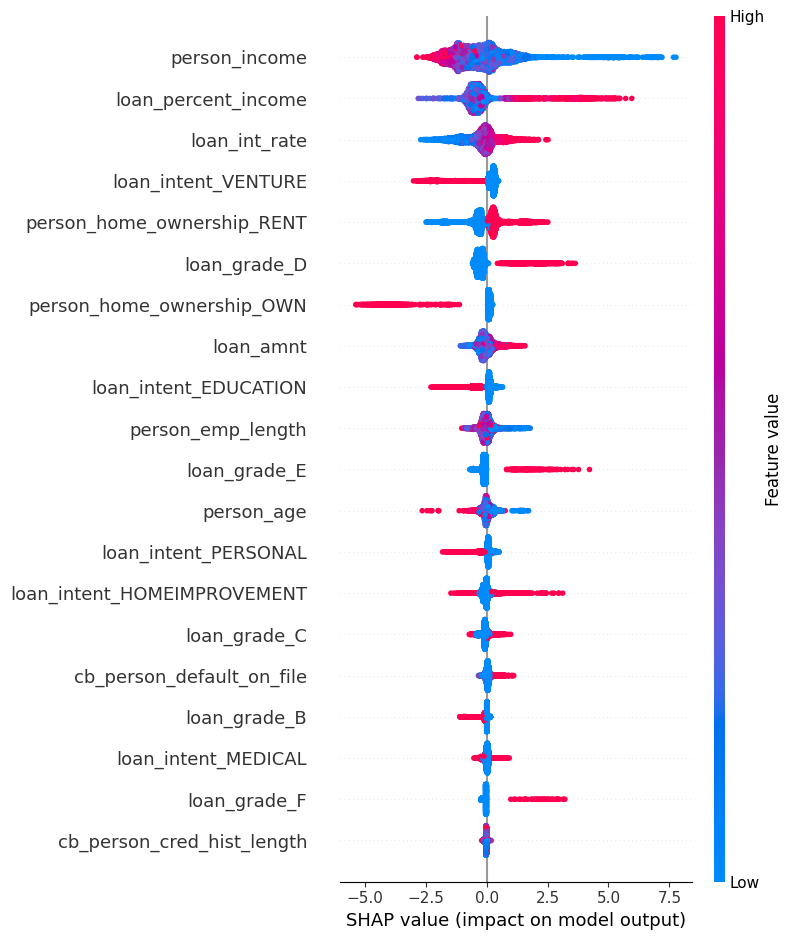

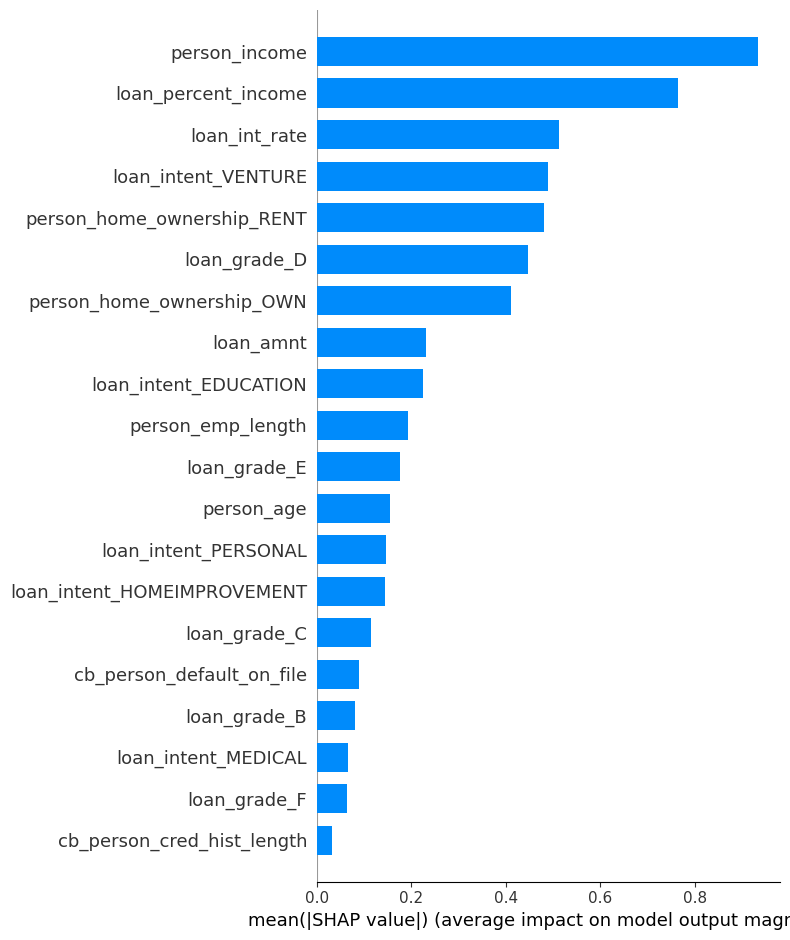

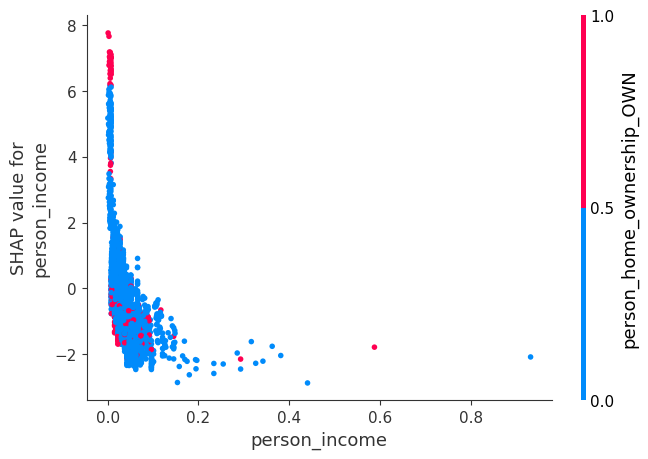

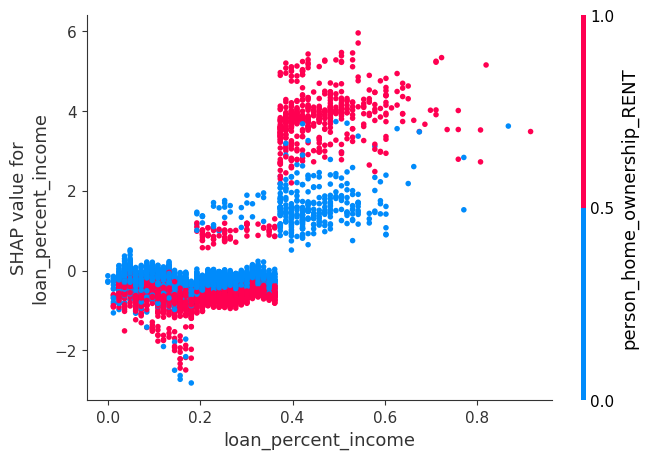

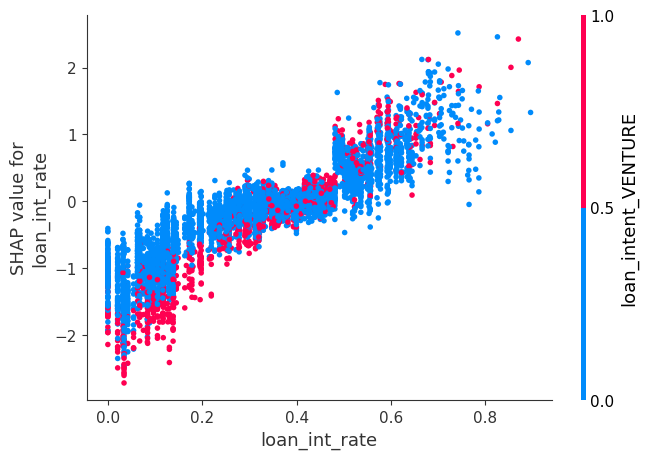

In [58]:
# =============================
# SHAP EXPLAINABILITY (RAW DATA)
# =============================

import shap

shap.initjs()

# 1️⃣ TreeExplainer for XGBoost
explainer = shap.TreeExplainer(best_model)

# 2️⃣ Compute SHAP values on original data
shap_values = explainer.shap_values(X_test_original)

# 3️⃣ Summary Plot
shap.summary_plot(shap_values, X_test_original)

# 4️⃣ Bar Plot
shap.summary_plot(shap_values, X_test_original, plot_type="bar")

# 5️⃣ Force plot for a single prediction
idx = 5
shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X_test_original.iloc[idx]
)

# 6️⃣ Dependence plot for top features
top_features = X_test_original.columns[np.argsort(np.abs(shap_values).mean(0))[::-1][:3]]

for f in top_features:
    shap.dependence_plot(f, shap_values, X_test_original)


### Single prediction SHAP

In [61]:
# =======================================
# SHAP SINGLE-PREDICTION EXPLANATION
# =======================================

import shap

shap.initjs()

# Pick which row to explain
index = 10
sample = X_test_original.iloc[index:index+1].copy()

# IMPORTANT: fix column order to match model training
sample = sample[best_model.get_booster().feature_names]

# Create explainer
explainer = shap.TreeExplainer(best_model)

# SHAP values for this sample
shap_values_single = explainer.shap_values(sample)

# Show prediction
prediction = best_model.predict(sample)[0]
prob = best_model.predict_proba(sample)[0][1]

print(f"Prediction: {prediction}")
print(f"Probability of Default: {prob:.4f}")

# Force plot
shap.force_plot(
    explainer.expected_value,
    shap_values_single,
    sample
)


Prediction: 0
Probability of Default: 0.0691


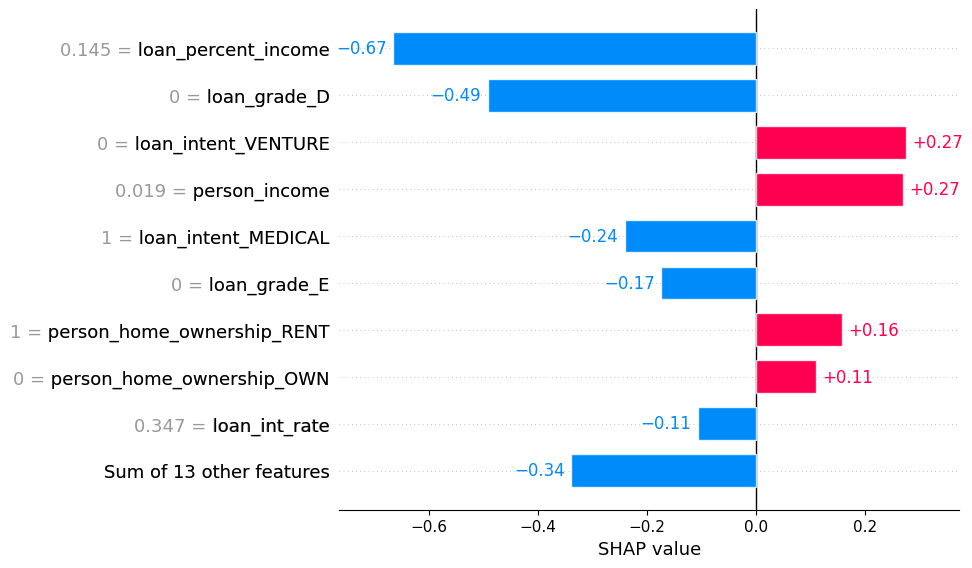

In [65]:
# Bar plot for single prediction
explanation = shap.Explanation(
    values=shap_values_single[0],
    base_values=explainer.expected_value,
    data=sample.iloc[0].values,
    feature_names=sample.columns.tolist()
)
shap.plots.bar(explanation, max_display=10)